In [55]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

a = 1
b = 2
k_r = 1.5
k_i = 1
v_1 = 1
v_2 = 1
v_3 = 1
c = np.log((a * a * v_1 + b * b * v_2 + a * b * v_3 + a * b * v_3) / ((2 * k_r) * (2 * k_r)))
print(sys.executable)
#周期性边界条件
x_lower = -10
x_upper = 10
t_lower = -2
t_upper =2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
    m0=1
    m1=1
    m2=1
    m3=1
    
    f_u1 = (
            v1_t + u1_xx
            + 2 * u1 * (m0 * (u1 ** 2 + v1 ** 2) + m1 * (u2 ** 2 + v2 ** 2) + (m2 + m3) * (u1 * u2 + v1 * v2))
           +2*v1*(m2-m3)*(u1*v2-v1*u2)
    )

    f_v1 = (
            u1_t - v1_xx
            - 2 * v1 * (m0 * (u1 ** 2 + v1 ** 2) + m1 * (u2 ** 2 + v2 ** 2) + (m2 + m3) * (u1 * u2 + v1 * v2))
           +2*u1*(m2-m3)*(u1*v2-v1*u2)
    )

    f_u2 = (
            v2_t + u2_xx
            + 2 * u2 * (m0 * (u1 ** 2 + v1 ** 2) + m1 * (u2 ** 2 + v2 ** 2) + (m2 + m3) * (u1 * u2 + v1 * v2))
           +2*v2*(m2-m3)*(u1*v2-v1*u2)
    )

    f_v2 = (
           u2_t - v2_xx
            - 2 * v2 * (m0 * (u1 ** 2 + v1 ** 2) + m1 * (u2 ** 2 + v2 ** 2) + (m2 + m3) * (u1 * u2 + v1 * v2))
           +2*u2*(m2-m3)*(u1*v2-v1*u2)
    )
    
    return [
        f_u1, f_v1, f_u2, f_v2,
        #f_u1x, f_u1t,
        #f_v1x, f_v1t,
        #f_u2x, f_u2t,
        #f_v2x, f_v2t
    ]
 # 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
#(e^c=...)
# 初始条件
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)
def init_cond_u1(x):
    "2 sech(x)"
    return (1/2) * np.cos(x[:, 0:1]) / np.cosh(1.5*x[:, 0:1])
def init_cond_u2(x):
    "2 tanh(x)"
    return np.cos(x[:, 0:1])/ np.cosh(1.5*x[:, 0:1])

def init_cond_v1(x):
    return (1/2) * np.sin(x[:, 0:1]) / np.cosh(1.5*x[:, 0:1])

def init_cond_v2(x):
    return np.sin(x[:, 0:1])/ np.cosh(1.5*x[:, 0:1])

ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 5 + [4], "silu", "Glorot normal")

model = dde.Model(data, net)


D:\anaconda\python.exe
D:\anaconda\python.exe


In [56]:

model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=3000, display_every=1000)


Compiling model...
Building feed-forward neural network...
'build' took 0.200719 s

'compile' took 12.983842 s

Initializing variables...
Training model...

0         [6.80e-05, 3.66e-05, 2.18e-05, 6.97e-05, 5.65e-04, 6.62e-04, 3.84e-03, 6.07e-04, 3.00e-02, 2.35e-03, 2.14e-02, 6.62e-05, 1.50e-02, 6.16e-03, 5.41e-02, 1.72e-02]    [6.80e-05, 3.66e-05, 2.18e-05, 6.97e-05, 5.65e-04, 6.62e-04, 3.84e-03, 6.07e-04, 3.00e-02, 2.35e-03, 2.14e-02, 6.62e-05, 1.50e-02, 6.16e-03, 5.41e-02, 1.72e-02]    []  
1000      [6.05e-04, 2.85e-04, 1.60e-03, 8.94e-04, 4.06e-07, 7.70e-07, 6.46e-06, 1.20e-06, 1.36e-05, 4.59e-06, 6.30e-06, 5.95e-06, 1.75e-04, 2.30e-04, 5.36e-04, 5.78e-04]    [6.05e-04, 2.85e-04, 1.60e-03, 8.94e-04, 4.06e-07, 7.70e-07, 6.46e-06, 1.20e-06, 1.36e-05, 4.59e-06, 6.30e-06, 5.95e-06, 1.75e-04, 2.30e-04, 5.36e-04, 5.78e-04]    []  
2000      [2.75e-04, 1.96e-04, 5.85e-04, 4.97e-04, 6.69e-06, 8.10e-07, 6.97e-07, 4.65e-07, 1.20e-05, 5.99e-06, 8.89e-06, 1.57e-06, 1.62e-04, 1.93e-04, 3.82e-

(<deepxde.model.LossHistory at 0x2d1fabe5f10>,
 <deepxde.model.TrainState at 0x2d1c7ede490>)

Compiling model...
'compile' took 9.240242 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
3000      [2.08e-04, 1.67e-04, 4.89e-04, 4.63e-04, 6.24e-06, 3.78e-07, 8.31e-07, 1.13e-06, 1.99e-06, 1.87e-06, 8.20e-06, 3.61e-06, 1.19e-04, 1.44e-04, 2.48e-04, 2.98e-04]    [2.08e-04, 1.67e-04, 4.89e-04, 4.63e-04, 6.24e-06, 3.78e-07, 8.31e-07, 1.13e-06, 1.99e-06, 1.87e-06, 8.20e-06, 3.61e-06, 1.19e-04, 1.44e-04, 2.48e-04, 2.98e-04]    []  
4000      [6.05e-05, 6.34e-05, 8.89e-05, 7.59e-05, 3.64e-07, 7.10e-08, 1.68e-07, 5.37e-07, 2.01e-07, 4.70e-07, 3.37e-07, 3.96e-07, 7.31e-06, 1.16e-05, 9.06e-06, 1.05e-05]                                                                        

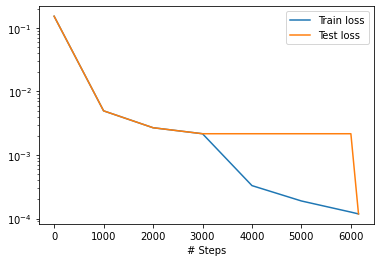

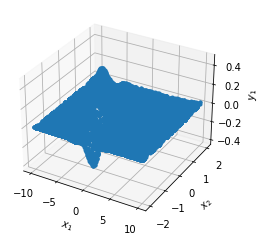

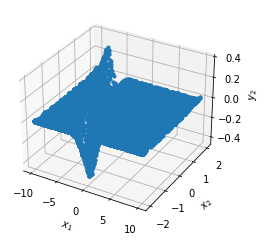

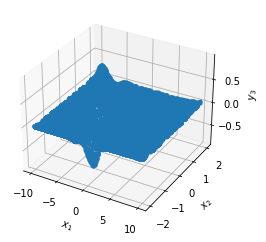

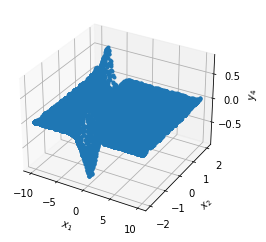

In [57]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=3000,
    maxfun=5000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()


In [ ]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:])



In [ ]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:]/10)

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)

In [ ]:
# X = geomtime.random_points(100000)
# err = 1
# while err > 0.005:
#     f = model.predict(X, operator=pde)
#     print(np.array(f).shape)
#     err_eq = np.absolute(f)
#     err = np.mean(err_eq)
#     print("Mean residual: %.3e" % (err))
#     err_eq=np.sum(err_eq,axis=0)
#     print(err_eq.shape)
#     x_id = np.argmax(err_eq)
#     print(x_id)
#     print("Adding new point:", X[x_id], "\n")
#     data.add_anchors(X[x_id])
#     early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
#     model.compile("adam", lr=1e-3)
#     model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
#     model.compile("L-BFGS")
#     losshistory, train_state = model.train(callbacks=[early_stopping])
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# X, y_true = gen_testdata(callbacks=[early_stopping])
# y_pred = model.predict(X)
# print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
# np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

In [ ]:
print(c)